# Task 2: Extension of ATHENA

# Introduction

## Transformation as a Weak Defense and Ensemble of many Diverse Weak Defenses
Transformations can be an effective way of deterring some adversarial perturbations. Some transformations are rotation (rotate the input by a certain angle such as 90, 180, and 270 degrees), flip (horizontally and/or vertically), and noise (add noise to the input, such as gaussian). Individually, each weak defense is capable of correctly classifying samples generated by certain methods, but likely to misclassify samples from other methods. For example, the morphology transformation correctly classifies adversarial examples generated by the Fast Gradient Sign Method (FGSM), while rotate(180) misclassifies the same adversaries. One approach to this limitation is the use of an ensemble of many diverse weak defenses (WD): while an adversary can be effective against a a few WD, it is unlikely that it can be effective against a large number of WD that complement each other.

In general terms, a weak defense is created by:

1 - Training: each WD $f_{t_i}$ is trained by applying a transformation, $t_i$, on the original data $D$, and then training a classifier using the transformed data set $D_{t_i}$.

2 - Testing: a transformation $t_i$ is applied to a given input $x$, generating the transformed input $x_{t_i}$, which is then fed to the corresponding WD $f_{t_i}$.

The standard implementation of ATHENA consists of using many diverse weak defenses and a fixed strategy, such as Majority Voting (MV) or Average Output (AVEO), to determine the prediction agreed upon by most WDs.

## Learning-based strategy
Instead of using a fixed strategy to determine the prediction, we aim to build a model that takes the predictions from weak defenses as the input and produces the final label for the input image $x$.  

### Create training and test dataset
The first step is collecting a three-dimensional array of probabilities that each weak defense generates given an input image. We obtain an array of dimensions (x, y, 10), where x is the number of weak defenses, y is the number of input images, and 10 is the probability that the input is each digit (0,1,2,...,9) in the MNIST dataset. A dataset is created by combining the predictions of all weak defenses and the true label of each digit. This dataset is separated into training and test sets.

### Learning ensamble strategy
We implemented three diferent models based on different functions:

#### Rectified linear unit (ReLU) activation function (Jarrett et al., 2009; Nair & Hinton, 2010; Glorot et al., 2011)
The ReLU is half rectified from bottom, meaning that it is defined by the positive part of its argument:

$$f(x)=x^+=max(0,x)$$

or

$$
f(x) = \left\{
    \begin{array}\\
        x\, \text{if}\, x\ >\ 0 \\
        0,\, \text{otherwise.}
    \end{array}
\right.
$$

This function simply preserves positive values and turns all negative values into zero.

#### Exponential Linear Unit (ELU) activation function (Clevert, Unterthiner, & Hochreiter, 2010)
This function is very similiar to RELU except it can have negative values. It also has an extra alpha constant which should be a positive number:
$$
f(x) = \left\{
    \begin{array}\\
        x\, \text{if}\, x\ >\ 0 \\
        \alpha (e^x - 1),\, \text{otherwise.}
    \end{array}
\right.
$$

#### Sigmoid logistic function
Sigmoid functions produce ‘S-shaped’ curves.  The logistic function in particular is symmetric around 0.5:

$$
f(x)=\frac{1}{1+e^{-x}}
$$

### Testing
The two ML models were trained either on the predictions of the weak defenses or on the the adversarial examples (AEs) generated in Task 1. They were then evaluated against a) the same type of attack they were trained on, b) benign samples (unadulterated images), and c) the alternative attack: either the baseline adversarial examples (generated from the weak defenses) or the adversarial examples (AEs) generated in Task 1. 

The AEs we retained from Task 1 are:

#### Attack 1: Fast Gradient Sign Method (FGSM; Goodfellow, Shlens, & Szegedy, 2015)
This method processes adversarial examples as follows:

$$ x' = x + \epsilon \cdot sign(\nabla_xJ(x,y)) $$

where $x'$ is the adversarial image, $J$ is the cost (loss) function of the target model $f$, $\nabla_x$ is the gradient with respect to the input $x$ (original image) with corresponding correct output $y$ (original label), and $\epsilon$ is the magnitude of the perturbation (the change made to the pixels).

Note that the $\epsilon$ parameter is a vector multiplier that ensures the perturbation is small - just large enough to provoke misclassification. We chose values of $\epsilon$ in the range of 0.1 to 1 in increments of 0.1 ($\epsilon$ = 0.1, 0.2, ..., 1.0).

#### Attack 2: Projected Gradient Descent (PGD; Madry, Makelov, Schmidt, Tsipras, & Vladu, 2019)
This is an iterative approach that gradually increases the magnitude of the perturbation until the input is misclassified. Like other methods, it aims to minimize the following worst case loss function over all possible perturbations:

$$\rho(\theta)=E_{(x,y)\sim D}\, \bigg[ \max\limits_{\delta\, \in\, S}L(\theta, x + \delta,y) \bigg]$$

The FGSM described previously approaches is an attack for an $l_\inf$-bounded adversary and generates adversarial examples as seen above. Another adversarial approach is a multi-step variant, which is the *projected gradient descent* (PGD) on the negative loss function

$$ x^{t+1} = \prod_{x+S}(x^t\ +\ \alpha sign(\nabla_x L(\theta,x,y))) $$

For the PGD, we generated attacks in two ways:
1. Manipulating the size of the perturbation, $\epsilon$, from 0.1 to 1 in increments of 0.1 with fixed maximum iteration of 10.
2. Manipulating the number of maximum iterations from 10 to 30 by increments of 2 (10,12,14,...,30) with a fixed $\epsilon$ of 0.3.



# Experimental settings 
We implemented models composed of four layers: an input layer, two fully connected layers with 128 units that are activated on the chosen functions (ReLU, ELU, or sigmoid), and the output layer corresponding to the ten possible classes.

For the learning ensemble strategy, two machine learning models were constructed. For the first model, 100 adversarial examples and predicted results were taken from each of the generated AEs from the weak defenses below. The ML model was trained on the first 4000 of the combined matrix of AEs and tested against the last 400.

The second ML model was created on AEs generated from our Task 1. Four hundred AEs and predicted results were taken from each of the 31 Generated AEs from Task 1.The ML model was then trained on the first 10,000 of the combined matrix of Task 1 AEs and tested against the last 2,400.

In both ML models, epoch was set to 7 steps.

#### Utilized weak defenses: list of transformations
Rotate (270 degrees);
Shift (left, bottom right);
Flip (horizontal);
Affine;
Morphology (gradient);
Augmentation (sample-wise std normalization);
Cartoonify (mean);
Quantization (k-mean = 8 clusters);
Distortion (x-axis);
Noise (gaussian, salt & pepper);
Filter (gaussian, rank);
Compress (.jpeg quality 80%);
Denoise (tv chambole);
Geometric (iradon);
Segmentation (gradient radius = 1, median radius = 2).


# Evaluation of defenses
We evaluated the models in terms of the loss function and accuracy. 

The results of each combination of model and choice of activation function is presented below.

## Weak defense models (TEST)


### ReLU

#### Model against itself
Loss = 0.03300371766090393
Accuracy = 0.987734317779541

#### Versus benign samples
Loss = 1.1565494537353516
Accuracy = 0.7325000166893005

#### Versus Task 1 AEs
Loss = 3.198460102081299
Accuracy = 0.5182575583457947
 

### ELU

#### Model against itself
Loss = 0.06850133836269379
Accuracy = 0.9784771800041199

#### Versus benign samples
Loss = 1.2455235719680786
Accuracy = 0.7232000231742859

#### Versus Task 1 AEs
Loss = 3.6784958839416504
Accuracy = 0.4919697046279907


### Sigmoid

#### Model against itself
Loss = 0.050099071115255356
Accuracy = 0.9868085980415344

#### Versus benign samples
Loss = 0.9333667159080505
Accuracy = 0.7351999878883362

#### Versus Task 1 AEs
Loss = 1.8960795402526855
Accuracy = 0.5644696950912476



## Task 1 AEs models (TEST)


### ReLU

#### Model against itself
Loss = 0.1645427942276001
Accuracy = 0.9370967745780945

#### Versus benign samples
Loss = 0.6949606537818909
Accuracy = 0.8353000283241272

#### Versus weak defense examples
Loss = 0.46949803829193115
Accuracy = 0.9034444689750671


### ELU

#### Model against itself
Loss = 0.13511227071285248
Accuracy = 0.9511290192604065

#### Versus benign samples
Loss = 0.8414720892906189
Accuracy = 0.8206999897956848

#### Versus weak defense examples
Loss = 0.4624998867511749
Accuracy = 0.8971111178398132


### Sigmoid

#### Model against itself
Loss = 0.20082779228687286
Accuracy = 0.935967743396759

#### Versus benign samples
Loss = 0.6430260539054871
Accuracy = 0.8149999976158142

#### Versus weak defense examples
Loss = 0.4694459140300751
Accuracy = 0.8652777671813965

In [15]:
# Import packages, load training results for weak defense ML model
import pandas as pd
import matplotlib.pyplot as plt
file1 = pd.read_csv('C:\\Users\\raulc\\Documents\\GitHub\\project-athena\\Part2_plots\\ML_Model_weakdef_Relu.csv')
file2 = pd.read_csv('C:\\Users\\raulc\\Documents\\GitHub\\project-athena\\Part2_plots\\ML_Model_weakdef_Elu.csv')
file3 = pd.read_csv('C:\\Users\\raulc\\Documents\\GitHub\\project-athena\\Part2_plots\\ML_Model_weakdef_Sigmoid.csv')

## 1) Accuracy on weak defenses (Training)

In [36]:
lines = file1.plot.line(x='epoch', y='acc')
plt.title('Learning curve: ReLU on WD')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim(0.6,1)
plt.show()

In [37]:
lines = file2.plot.line(x='epoch', y='acc')
plt.title('Learning curve: ELU on WD')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim(0.6,1)
plt.show()

In [38]:
lines = file3.plot.line(x='epoch', y='acc')
plt.title('Learning curve: Sigmoid on WD')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim(0.6,1)
plt.show()

## 2) Accuracy on Task 1 adversarial examples (Training)

In [19]:
# Load training results Task 1 AE ML model
file4 = pd.read_csv('C:\\Users\\raulc\\Documents\\GitHub\\project-athena\\Part2_plots\\ML_Model_Task1AE_Relu.csv')
file5 = pd.read_csv('C:\\Users\\raulc\\Documents\\GitHub\\project-athena\\Part2_plots\\ML_Model_Task1AE_Elu.csv')
file6 = pd.read_csv('C:\\Users\\raulc\\Documents\\GitHub\\project-athena\\Part2_plots\\ML_Model_Task1AE_Sigmoid.csv')


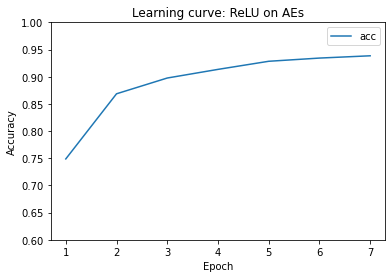

In [39]:
lines = file4.plot.line(x='epoch', y='acc')
plt.title('Learning curve: ReLU on AEs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim(0.6,1)
plt.show()

In [40]:
lines = file5.plot.line(x='epoch', y='acc')
plt.title('Learning curve: ELU on AEs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim(0.6,1)
plt.show()

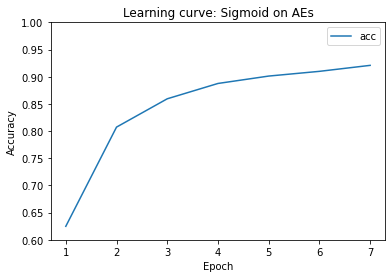

In [41]:
lines = file6.plot.line(x='epoch', y='acc')
plt.title('Learning curve: Sigmoid on AEs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim(0.6,1)
plt.show()

## 3) Loss on weak defenses (Training)

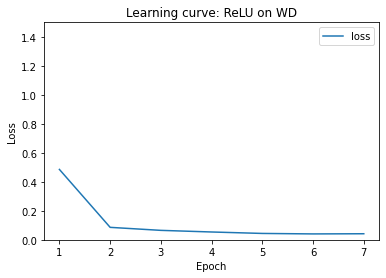

In [45]:
lines = file1.plot.line(x='epoch', y='loss')
plt.title('Learning curve: ReLU on WD')
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim(0,1.5)
plt.show()

In [46]:
lines = file2.plot.line(x='epoch', y='loss')
plt.title('Learning curve: ELU on WD')
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim(0,1.5)
plt.show()

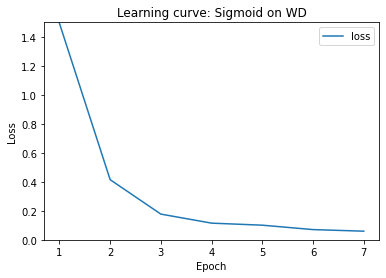

In [47]:
lines = file3.plot.line(x='epoch', y='loss')
plt.title('Learning curve: Sigmoid on WD')
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim(0,1.5)
plt.show()

## 4) Loss on Task 1 adversarial examples (Training)

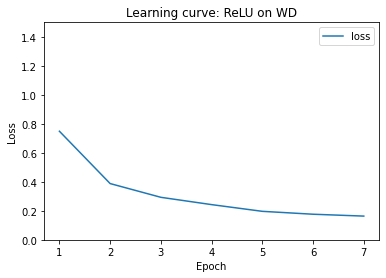

In [48]:
lines = file4.plot.line(x='epoch', y='loss')
plt.title('Learning curve: ReLU on WD')
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim(0,1.5)
plt.show()

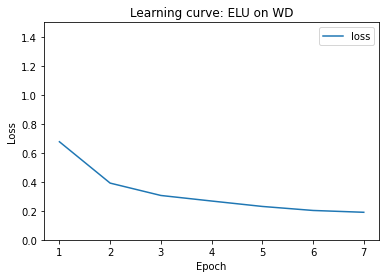

In [49]:
lines = file5.plot.line(x='epoch', y='loss')
plt.title('Learning curve: ELU on WD')
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim(0,1.5)
plt.show()

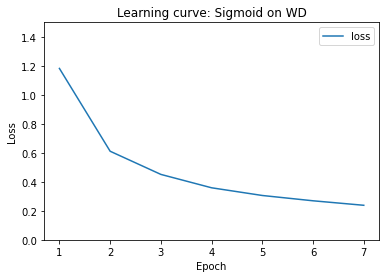

In [50]:
lines = file6.plot.line(x='epoch', y='loss')
plt.title('Learning curve: Sigmoid on WD')
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax = plt.gca()
ax.set_ylim(0,1.5)
plt.show()

# References
Clevert, D.-A., Unterthiner, T., and Hochreiter, S. (2015). Fast and accurate deep network learning
by exponential linear units (elus). arXiv preprint arXiv:1511.07289

Glorot, X., Bordes, A. & Bengio, Y.. (2011). Deep Sparse Rectifier Neural Networks. Proceedings of the Fourteenth International Conference on Artificial Intelligence and Statistics, in PMLR 15:315-323

Goodfellow, I.J., Shlens, J., & Szegedy, C. (2015). Explaining and Harnessing Adversarial Examples. CoRR, abs/1412.6572.

K. Jarrett, K. Kavukcuoglu, M. Ranzato and Y. LeCun. (2009). "What is the best multi-stage architecture for object recognition?," 2009 IEEE 12th International Conference on Computer Vision, 2146-2153. doi: 10.1109/ICCV.2009.5459469.

Madry, A., Makelov, A., Schmidt, L., Tsipras, D., & Vladu, A. (2018). Towards Deep Learning Models Resistant to Adversarial Attacks. ArXiv, abs/1706.06083.

Nair, Vinod, & Hinto, Geoffrey E.. (2010). Rectified linear units improve restricted boltzmann machines. Proceedings of the 27th International Conference on International Conference on Machine Learning (ICML'10), 807–814.
